In [31]:
%%capture --no-stderr
%pip install --quiet -U numpy opencv-python rasterio matplotlib scikit-image


In [18]:
import cv2
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

Simple DOS

In [18]:
def dark_object_subtraction(image_path, percentile=0.1):

    # Read the image in BGR format
       # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image is None:
        raise ValueError(f"Could not read image from {image_path}")

    # Assume image is a NumPy array (BGR or multispectral)
    dark_pixel = np.percentile(image, percentile, axis=(0, 1))
    corrected = np.clip(image - dark_pixel, 0, 255).astype(np.uint8)
    return corrected

In [20]:
# Example usage
corrected_image = dark_object_subtraction("testfiles/DJI_0025-h60.jpeg")
cv2.imwrite("corrected_image.jpeg", corrected_image)

True

Complex DOS and RC

In [15]:
def rigorous_radiometric_correction_rasterio(image_path, gain, offset, sunelev, edist, Esun, blackadjust=0.01, percentile=0.1):
    """
    Perform rigorous radiometric correction for a multispectral image using rasterio.
    
    Parameters:
      image_path (str): Path to the multispectral image
      gain (array-like): Sensor gain for each band
      offset (array-like): Sensor offset for each band
      sunelev (float): Sun elevation in degrees
      edist (float): Earth–Sun distance (in astronomical units)
      Esun (array-like): Exo-atmospheric solar irradiance for each band
      blackadjust (float): Adjustment factor for dark object subtraction
      percentile (float): Percentile for dark object estimation
      
    Returns:
      np.ndarray: Corrected reflectance image
    """
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (bands, H, W)
    
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Get number of bands
    n_bands, h, w = image.shape
    
    # Convert digital numbers (DN) to radiance: Radiance = gain * DN + offset
    radiance = np.empty_like(image)
    for i in range(n_bands):
        radiance[i, :, :] = gain[i] * image[i, :, :] + offset[i]
    
    # Compute sun zenith angle
    sun_zenith = 90 - sunelev
    cos_sun_zenith = np.cos(np.deg2rad(sun_zenith))
    Esun = np.array(Esun)
    
    # Convert radiance to reflectance
    reflectance = (np.pi * radiance) / (Esun[:, None, None] * cos_sun_zenith)
    reflectance /= edist ** 2
    
    # Estimate dark object value per band
    dark_obj = np.percentile(reflectance, percentile, axis=(1, 2))
    dark_obj_adj = dark_obj * (1 - blackadjust)
    
    # Apply dark object subtraction and clip
    corrected = np.clip(reflectance - dark_obj_adj[:, None, None], 0, 1)
    
    return corrected


In [23]:
# Example usage:
if __name__ == "__main__":
    image_path = "testfiles/20180627_seq_50m_NC.tif"
    gain = [0.1, 0.11, 0.09, 0.1, 0.12]  # 5-band sensor
    offset = [1, 1, 1, 1, 1]
    sunelev = 60.0
    edist = 1.0
    Esun = [1800, 1700, 1600, 1500, 1400]
    
    corrected_reflectance = rigorous_radiometric_correction_rasterio(
        image_path, gain, offset, sunelev, edist, Esun, blackadjust=0.01, percentile=0.1
    )
    
    # Save corrected reflectance as a new GeoTIFF
    with rasterio.open(image_path) as src:
        profile = src.profile.copy()
        profile.update(dtype=rasterio.float32, count=corrected_reflectance.shape[0])
    
    output_path = "corrected_reflectance.tif"
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(corrected_reflectance.astype(np.float32))
    
    # Visualization (convert to 8-bit)
    vis = (corrected_reflectance * 255).astype(np.uint8)
    vis_output_path = "corrected_reflectance_vis.tif"
    with rasterio.open(vis_output_path, 'w', **profile) as dst:
        dst.write(vis)

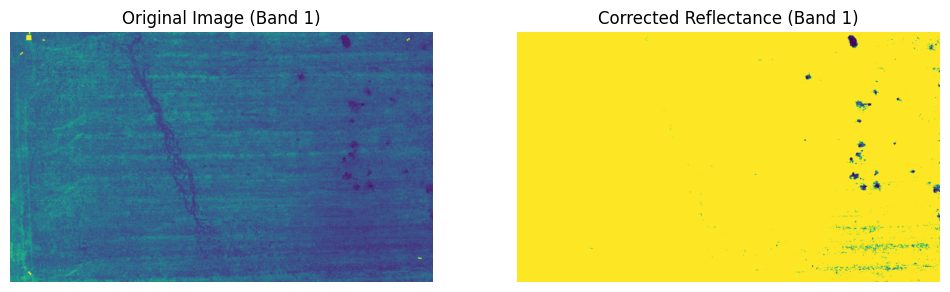

In [28]:
def plot_images(original_path, corrected_array, band=0):
    """
    Plot the original and corrected images for a given band.

    Parameters:
      original_path (str): Path to the original image.
      corrected_array (np.ndarray): Radiometrically corrected reflectance array (bands, height, width).
      band (int): Band index to visualize (0-based indexing).

    """
    # Load original image
    with rasterio.open(original_path) as src:
        original = src.read(band + 1)  # Raster bands are 1-indexed

    # Normalize original image
    min_o, max_o = np.min(original), np.max(original)
    original_norm = (original - min_o) / (max_o - min_o) if max_o > min_o else original

    # Normalize corrected image (bands, height, width)
    corrected_band = corrected_array[band, :, :]
    min_c, max_c = np.min(corrected_band), np.max(corrected_band)
    corrected_norm = (corrected_band - min_c) / (max_c - min_c) if max_c > min_c else corrected_band

    # Plot both images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(original_norm, cmap='viridis')
    ax[0].set_title(f"Original Image (Band {band + 1})")
    ax[0].axis("off")

    ax[1].imshow(corrected_norm, cmap='viridis')
    ax[1].set_title(f"Corrected Reflectance (Band {band + 1})")
    ax[1].axis("off")

    plt.show()

# Call the function after running your correction process
plot_images("testfiles/20180627_seq_50m_NC.tif", corrected_reflectance, band=0)

Implementing Geometric correction

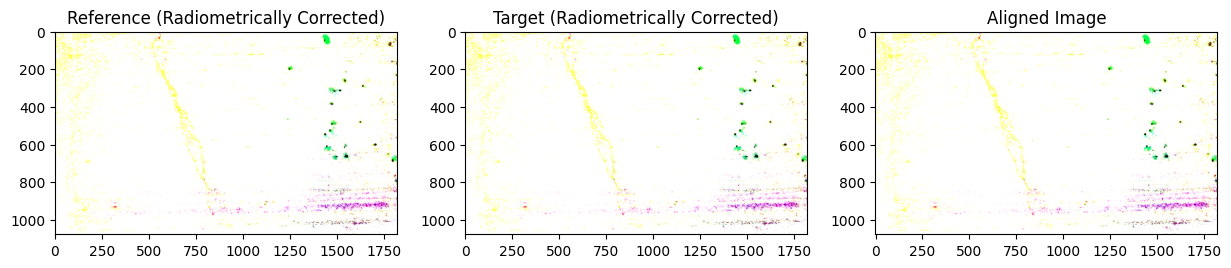

Single image RMSE: 7.569670187572857e-14


In [46]:
import os
import numpy as np
import concurrent.futures
import rasterio
from skimage.color import rgb2gray  # Not used directly here but available if needed
from skimage.feature import ORB, match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, warp
from skimage.io import imsave
import matplotlib.pyplot as plt

def rigorous_radiometric_correction_rasterio(image_path, gain, offset, sunelev, edist, Esun, blackadjust=0.01, percentile=0.1):
    """
    Perform rigorous radiometric correction for a multispectral image using rasterio.
    
    Parameters:
      image_path (str): Path to the multispectral image.
      gain (array-like): Sensor gain for each band.
      offset (array-like): Sensor offset for each band.
      sunelev (float): Sun elevation in degrees.
      edist (float): Earth–Sun distance (in astronomical units).
      Esun (array-like): Exo-atmospheric solar irradiance for each band.
      blackadjust (float): Adjustment factor for dark object subtraction.
      percentile (float): Percentile for dark object estimation.
      
    Returns:
      np.ndarray: Corrected reflectance image in shape (bands, H, W) with values in [0,1].
    """
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (bands, H, W)
    
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    n_bands, h, w = image.shape
    radiance = np.empty_like(image)
    for i in range(n_bands):
        radiance[i, :, :] = gain[i] * image[i, :, :] + offset[i]
    
    sun_zenith = 90 - sunelev
    cos_sun_zenith = np.cos(np.deg2rad(sun_zenith))
    Esun = np.array(Esun)
    reflectance = (np.pi * radiance) / (Esun[:, None, None] * cos_sun_zenith)
    reflectance /= edist**2
    
    dark_obj = np.percentile(reflectance, percentile, axis=(1, 2))
    dark_obj_adj = dark_obj * (1 - blackadjust)
    corrected = np.clip(reflectance - dark_obj_adj[:, None, None], 0, 1)
    return corrected

def compute_homography_sk(ref_img, tgt_img, detector_type='ORB'):
    """
    Computes the projective transform (homography) between two images using scikit-image.
    
    Parameters:
      ref_img (np.ndarray): Reference image in (H, W, channels) format.
      tgt_img (np.ndarray): Target image in (H, W, channels) format.
      detector_type (str): Feature detector type ('ORB' supported here).
      
    Returns:
      ProjectiveTransform: Estimated projective transform.
    """
    # Convert multispectral images to grayscale by taking the mean over bands.
    ref_gray = np.mean(ref_img, axis=2) if ref_img.ndim == 3 else ref_img
    tgt_gray = np.mean(tgt_img, axis=2) if tgt_img.ndim == 3 else tgt_img

    # Initialize ORB detector
    orb = ORB(n_keypoints=500)
    orb.detect_and_extract(ref_gray)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors

    orb.detect_and_extract(tgt_gray)
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors

    matches = match_descriptors(descriptors1, descriptors2, cross_check=True)
    if len(matches) < 4:
        raise RuntimeError("Not enough matches to compute homography.")
    
    src = keypoints1[matches[:, 0]]
    dst = keypoints2[matches[:, 1]]
    
    model_robust, inliers = ransac((src, dst), ProjectiveTransform, min_samples=4,
                                   residual_threshold=2, max_trials=1000)
    return model_robust

def warp_image_sk(image, transform, output_shape):
    """
    Warps the image using the given projective transform.
    
    Parameters:
      image (np.ndarray): Image in (H, W, channels) format.
      transform (ProjectiveTransform): Estimated transform.
      output_shape (tuple): Desired output shape (H, W, channels).
      
    Returns:
      np.ndarray: Warped (aligned) image.
    """
    warped = warp(image, inverse_map=transform.inverse, output_shape=output_shape)
    return warped

def validate_alignment(ref_img, aligned_img):
    """
    Computes the RMSE between the reference and aligned images.
    
    Parameters:
      ref_img (np.ndarray): Reference image in (H, W, channels) format.
      aligned_img (np.ndarray): Aligned image in (H, W, channels) format.
      
    Returns:
      float: RMSE value.
    """
    diff = (ref_img - aligned_img) ** 2
    return np.sqrt(np.mean(diff))

def geometric_correction_pipeline(reference_image_path, target_image_path, radiometric_params, detector_type='ORB', visualize=False):
    """
    Executes the full pipeline: radiometric correction using rasterio followed by
    geometric correction using scikit-image.
    
    Parameters:
      reference_image_path (str): Path to the reference image.
      target_image_path (str): Path to the target image.
      radiometric_params (dict): Radiometric parameters for correction.
      detector_type (str): Feature detector type (only 'ORB' supported).
      visualize (bool): If True, displays the corrected images.
      
    Returns:
      tuple: (Estimated transform, aligned image in (H, W, channels) format, RMSE)
    """
    try:
        # Apply radiometric correction to both images (result shape: (bands, H, W))
        ref_corr = rigorous_radiometric_correction_rasterio(reference_image_path, **radiometric_params)
        tgt_corr = rigorous_radiometric_correction_rasterio(target_image_path, **radiometric_params)
        
        # Transpose images to (H, W, bands) for geometric processing
        # ref_img = np.transpose(ref_corr, (1, 2, 0))
        ref_img = np.transpose(ref_corr, (1, 2, 0))
        tgt_img = np.transpose(tgt_corr, (1, 2, 0))
        
        # Compute projective transform using scikit-image
        transform = compute_homography_sk(ref_img, tgt_img, detector_type)
        
        # Warp the target image using the estimated transform
        aligned_img = warp_image_sk(tgt_img, transform, ref_img.shape)
        
        # Compute RMSE between the reference and aligned images
        rmse = validate_alignment(ref_img, aligned_img)
        
        if visualize:
            def prepare_display(img):
                # If image has more than 3 bands, select the first 3 for an RGB composite.
                if img.shape[2] >= 3:
                    return img[..., :3]
                return img
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(prepare_display(ref_img))
            plt.title("Reference (Radiometrically Corrected)")
            plt.subplot(1, 3, 2)
            plt.imshow(prepare_display(tgt_img))
            plt.title("Target (Radiometrically Corrected)")
            plt.subplot(1, 3, 3)
            plt.imshow(prepare_display(aligned_img))
            plt.title("Aligned Image")
            plt.show()

        
        return transform, aligned_img, rmse
    except Exception as e:
        raise RuntimeError(f"Error in geometric correction pipeline: {e}")

def batch_geometric_correction(reference_image_path, target_images_dir, output_dir, radiometric_params, detector_type='ORB', max_workers=4):
    """
    Processes multiple target images in parallel using the geometric correction pipeline.
    
    Parameters:
      reference_image_path (str): Path to the reference image.
      target_images_dir (str): Directory containing target images.
      output_dir (str): Directory where aligned images will be saved.
      radiometric_params (dict): Radiometric parameters for correction.
      detector_type (str): Feature detector type.
      max_workers (int): Number of parallel workers.
      
    Returns:
      None
    """
    os.makedirs(output_dir, exist_ok=True)
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')
    target_image_paths = [os.path.join(target_images_dir, fname) 
                          for fname in os.listdir(target_images_dir) 
                          if fname.lower().endswith(valid_extensions)]
    
    def process_image(img_path):
        try:
            transform, aligned_img, rmse = geometric_correction_pipeline(
                reference_image_path, img_path, radiometric_params, detector_type, visualize=False)
            # Scale to 8-bit for saving (aligned_img is float [0,1])
            save_img = (aligned_img * 255).astype(np.uint8)
            output_path = os.path.join(output_dir, os.path.basename(img_path))
            imsave(output_path, save_img)
            print(f"Processed {img_path}, RMSE: {rmse:.4f}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        executor.map(process_image, target_image_paths)

if __name__ == "__main__":
    radiometric_params = {
        'gain': [0.1, 0.11, 0.09, 0.1, 0.1],
        'offset': [1, 1, 1, 1, 1],
        'sunelev': 60.0,
        'edist': 1.0,
        'Esun': [1800, 1700, 1600, 1500, 1400],
        'blackadjust': 0.01,
        'percentile': 0.1
    }
    
    reference_image_path = "testfiles/20180627_seq_50m_NC.tif"
    target_image_path = "testfiles/20180627_seq_50m_NC copy.tif"
    
    # Run geometric correction for a single image and visualize results
    transform, aligned_img, rmse = geometric_correction_pipeline(reference_image_path, target_image_path, radiometric_params, detector_type='ORB', visualize=True)
    print("Single image RMSE:", rmse)
    
    # Run batch geometric correction for multiple target images
    # batch_geometric_correction(reference_image_path, "testfiles/target_images", "testfiles/aligned_images", radiometric_params, detector_type='ORB', max_workers=4)
